In [3]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
# import datetime as dt
from datetime import datetime

import time
# import datetime.datetime



from keras import layers
from keras import models
# from keras import optimizers
from tensorflow.keras import optimizers

from keras.applications.densenet import DenseNet121, DenseNet169
#from keras.applications.nasnet import NASNetLarge
# from keras_efficientnets import EfficientNetB7
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras import backend as K

tf.set_random_seed(1234)
random.seed(100)

os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

from ABNmodules import *


loss_function = 'categorical_crossentropy'
activation_function = 'softmax'


/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [4]:
def score_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [5]:
# n=3, kernelsize= 10, epoch 100, best_acc = 0.613
minimum_len=2880
model_dir = '/home/taejoon/PhysioNetChallenge/results_20200529_0_IEEE_n=1'

bestmodel = 'ECG_ABN_E70L0.41'
model = get_custom_model((None, 12), 9, minimum_len, 1, out_ch=256, n=1)

model.compile(loss=loss_function,
              optimizer=optimizers.Adam(lr=1e-5),           
              metrics=[score_f1])
# model.compile(loss=[loss_function, loss_function],
              
              
#               optimizer=optimizers.Adam(lr=1e-5),
          
#               metrics=[score_f1])


# model.load_weights(os.path.join(model_dir, bestmodel))


# model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model.summary()
model.load_weights(os.path.join(model_dir, bestmodel))



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, 12)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 64)     2368        input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     12352       batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())
    return sorted(unique_classes)

def one_hot_encoding(one_hot_vector,y, class2index):
    ind=class2index[y]
    one_hot_vector[ind]=1
    return one_hot_vector

# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)
        #print(start)
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

def exploratory_look(input_directory,file, class2index):
    classes = []
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp     

# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

def randextract_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len, x_mean_final, x_std_final):
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        #print(clip_file.shape)
        #clip_file = tmp_file[:minimum_len]
        clip_file -= x_mean_final
        clip_file /= x_std_final
        mel_files.append(clip_file)
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    concat = list(zip(mel_files, classes))
    random.shuffle(concat)
    mel_files, classes = zip(*concat)
    return mel_files, classes

def train(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final): 
    loss=[]
    acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps):
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)
        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
        train_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss.append(train_tmp[0])
        acc.append(train_tmp[1])
        f1.append(train_tmp[2])

    loss = np.mean(np.array(loss))
    acc = np.mean(np.array(acc))
    f1 = np.mean(np.array(f1))
    return loss, acc, f1

def test(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    mel_files = []
    classes = []
    for i, file in enumerate(data):
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            mel_files.append(clip_file)
        mel_files = np.asarray(mel_files)
        logit = model.predict(mel_files)
        logit = np.mean(logit, axis=0)
        pred = np.argmax(logit)
        label = np.argmax(get_labels(input_directory, file, class2index))
        #f1 = f1_score(label, logit)
        #print(pred, label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        #total_f1 += f1
    final_acc = total_acc / i
    #final_f1 = total_f1 / i
    return final_acc#, final_f1

batch_size = 32
minimum_len = 2880

epochs = 1000
loss_function = 'categorical_crossentropy'
activation_function = 'softmax'
rootdir = '../'
date = datetime.today().strftime("%Y%m%d")
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Raw_data_20200424' 
mel_directory = os.path.join(rootdir, mel_name)
results_directory = os.path.join(rootdir, 'results_'+date+'_0')
if not os.path.isdir(input_directory):
    os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
    os.mkdir(mel_directory)
if not os.path.isdir(results_directory):
    os.mkdir(results_directory)
        
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
input_file_names = sorted(input_files)

unique_classes = get_unique_classes(input_directory, input_files)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a
index2class = {y:x for x,y in class2index.items()}    
classes_orig= [x.replace('.mat', '.hea') for x in input_file_names] # total subjects
classes_multi, _, _ = searching_overlap(input_directory,class2index, input_file_names)
classes_single = [x for x in classes_orig if x not in classes_multi]
classes_single = [x.replace('.hea', '.mat') for x in classes_single]

# double-checking if classes_single have single-label
a, b, c  = searching_overlap(input_directory,class2index,classes_single)

# we can safely use classes_single as input_file_names
input_file_names = classes_single
random.shuffle(input_file_names)
np.shape(input_file_names)

x_mean_all = []
x_std_all = []

for file in input_file_names:
    x = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    x_mean = [np.mean(x[:,0]), np.mean(x[:,1]), np.mean(x[:,2]), np.mean(x[:,3]), np.mean(x[:,4]), np.mean(x[:,5]),
             np.mean(x[:,6]), np.mean(x[:,7]), np.mean(x[:,8]), np.mean(x[:,9]), np.mean(x[:,10]), np.mean(x[:,11])]
    
    x_std = [np.std(x[:,0]), np.std(x[:,1]), np.std(x[:,2]), np.std(x[:,3]), np.std(x[:,4]), np.std(x[:,5]),
             np.std(x[:,6]), np.std(x[:,7]), np.std(x[:,8]), np.std(x[:,9]), np.std(x[:,10]), np.std(x[:,11])]
    #print(x_mean)
    x_mean_all.append(x_mean)
    x_std_all.append(x_mean)
x_mean_final = np.mean(x_mean_all, axis=0)
x_std_final = np.mean(x_std_all, axis=0)
print(x_mean_final)

data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True)
data_train, data_val = train_test_split(data, test_size = 0.25, train_size = 0.75, shuffle=True)
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))

[-2.24290386e-03 -4.58280585e-05  4.31697309e-03 -3.00174693e-03
 -2.36609229e-04  1.28997408e-03  2.17347589e-04 -7.99152384e-04
 -3.42993744e-03 -1.69711686e-03  1.27138164e-03  1.94670545e-03]
(3840,) (1280,) (1281,)


In [8]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_branch_att_sigmoid_1').output])




In [9]:
# model2 = Model(inputs=model.input,
#               outputs=[model.output, model.get_layer('attention_branch_att_sigmoid_1').output])


In [14]:
file=data_train[0]
file = 'A4459.mat' # multiclass; [1 0 0 0 0 0 1 0 0]
tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
clip_file = block_feature(tmp_file, minimum_len)

clip_file -= x_mean_final
clip_file /= x_std_final
clip_file.shape

preprocessed_input=clip_file

preprocessed_input.shape


(2880, 12)

In [15]:
file


'A4459.mat'

In [16]:
preprocessed_input = np.reshape(preprocessed_input, (1,minimum_len,12))

preprocessed_input.shape


(1, 2880, 12)

In [17]:
outputs = model.predict(preprocessed_input)


In [18]:
outputs

[array([[0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32),
 array([[[0.        ],
         [0.        ],
         [0.42041826],
         [1.        ],
         [1.        ],
         [1.        ],
         [0.42041826],
         [0.        ],
         [0.42041826],
         [0.        ],
         [1.        ],
         [0.        ]]], dtype=float32)]

In [19]:
outputs[2].shape

(1, 12, 1)

In [20]:
att_map = outputs[2]


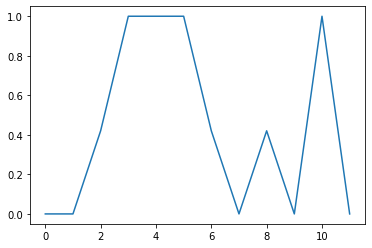

In [21]:
plt.plot(np.squeeze(outputs[2]))



In [16]:
import cv2
resize_att = cv2.resize(outputs[2], (2880,1))
resize_att.shape


(1, 2880)

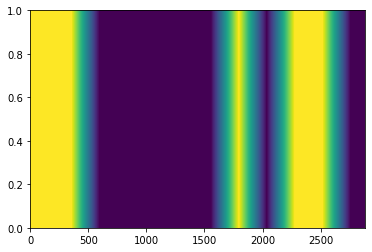

In [17]:
import seaborn as sns
plt.pcolor(resize_att)


In [18]:
dot = np.squeeze(preprocessed_input) * np.transpose(resize_att)
dot.shape




(2880, 12)

In [19]:
dot[:,0].shape




(2880,)

In [20]:
# 정규화!!!
x_mean_all = []
x_std_all = []
x=preprocessed_input
x_mean = [np.mean(x[:,:,0]), np.mean(x[:,:,1]), np.mean(x[:,:,2]), np.mean(x[:,:,3]), np.mean(x[:,:,4]), np.mean(x[:,:,5]),
             np.mean(x[:,:,6]), np.mean(x[:,:,7]), np.mean(x[:,:,8]), np.mean(x[:,:,9]), np.mean(x[:,:,10]), np.mean(x[:,:,11])]
    
x_std = [np.std(x[:,:,0]), np.std(x[:,:,1]), np.std(x[:,:,2]), np.std(x[:,:,3]), np.std(x[:,:,4]), np.std(x[:,:,5]),
             np.std(x[:,:,6]), np.std(x[:,:,7]), np.std(x[:,:,8]), np.std(x[:,:,9]), np.std(x[:,:,10]), np.std(x[:,:,11])]
    #print(x_mean)
x_mean_all.append(x_mean)
x_std_all.append(x_std)

x_mean_final = np.mean(x_mean_all, axis=0)
x_std_final = np.mean(x_std_all, axis=0)

clip_file -= x_mean_final
clip_file /= x_std_final



dot2 = np.squeeze(clip_file) * np.transpose(resize_att)


In [21]:
x_std



[37230.87576704218,
 2617660.0415947833,
 20482.742443348103,
 31118.438727969853,
 260564.25658353965,
 74994.85062736782,
 398919.2006459064,
 287609.00823690766,
 60127.67014902226,
 114469.37632492562,
 191716.03619842505,
 97011.12775851591]

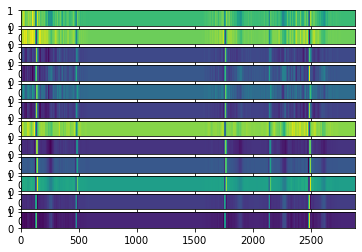

In [22]:
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.pcolor(np.reshape(dot2[:,i], (1,2880)))
    

In [23]:
clip_file.shape


(2880, 12)

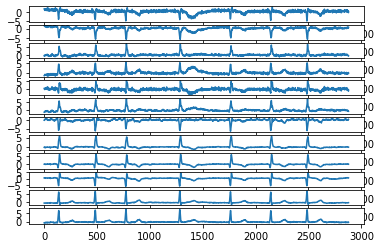

In [24]:
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.reshape(clip_file[:,i], (2880,1)))
    
    

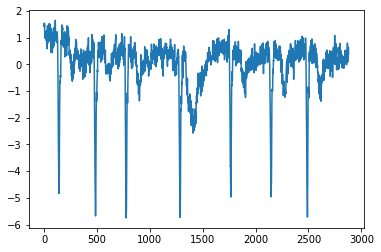

In [25]:
plt.plot(np.reshape(preprocessed_input[0,:,1],(2880,1)))

In [26]:
label = get_labels(input_directory, file, class2index)
label

[1, 0, 0, 0, 0, 0, 0, 0, 0]

In [27]:
class2index


{'AF': 0,
 'I-AVB': 1,
 'LBBB': 2,
 'Normal': 3,
 'PAC': 4,
 'PVC': 5,
 'RBBB': 6,
 'STD': 7,
 'STE': 8}

[0, 0, 0, 0, 0, 0, 1, 0, 0]

In [26]:
clip_file2 = clip_file

In [22]:
from ABNmodules import *
minimum_len = 2880


model_dir = '/home/taejoon/PhysioNetChallenge/results_20200601_1_CAM_primitive_model'
bestmodel = 'ECG_ABN_E87L0.33'
model2 = load_model(os.path.join(model_dir, bestmodel), custom_objects={'score_f1' : score_f1})
# latest = tf.train.latest_checkpoint(CAM_model_dir)
# latest
# model2.load_weights(latest)
model2.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, 12)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          2368      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          12352     
_____________________________________

In [113]:
def CAM_conv1D(model2, conv_layer, softmax_layer, minimum_len, 
                    n_channels, x, y, out_len):
    
    # x랑 y는 batch size만큼의 리스트 (32)
    heatmaps_orig=[]    
    
    curr_x = np.asarray(x)
    curr_x = curr_x.reshape(len(x),minimum_len,n_channels)
    get_conv_out = K.function(model2.input, [model2.get_layer(conv_layer).output, model2.get_layer(softmax_layer).weights[0]])
    conv_out, softmax_weights = get_conv_out(curr_x)
    print(softmax_weights.shape)
    for i in range(len(x)):
        heatmaps = []
        curr_classes = y[i]
        class_index=[]
        [class_index.append(j) for j in range(len(curr_classes)) if curr_classes[j]==1]
#         print(class_index)
        heatmap=np.zeros((1,36)) # might need to fix this if GradCAM or primitive model changes
        
        conv_out_ = conv_out[i] # (36, 128)


        for i,label in enumerate(class_index):  # multiclass일 경우 대비해서 for문
#             print(label)
            curr_weights = softmax_weights[:,label]
            weighted_conv = conv_out_*curr_weights
            
            weighted_conv = weighted_conv.sum(axis=-1) # output = (1,36)
            heatmaps_orig.append(weighted_conv)
            plt.subplot(2,1,i+1)
            temp = weighted_conv.reshape(1,36)
            plt.imshow(np.resize(temp, (1,out_len)))
            
            heatmap += weighted_conv
            

        heatmap %= len(class_index) # 단일 class일 경우 1로 나눠짐. 두개일 경우 더해진 heatmap들이 2로 나눠짐
#         print(len(class_index))
        heatmap = np.resize(heatmap, (1,out_len))
#         heatmap = np.resize(heatmap, (out_len, 1))
        heatmaps.append(heatmap)
        
    return heatmaps, heatmaps_orig

In [24]:
model2.get_layer('dense_final').weights[0]

<tf.Variable 'dense_final/kernel:0' shape=(128, 9) dtype=float32>

In [28]:
label2 = [1, 0, 0, 0, 0, 0, 1, 0, 0]

(128, 9)


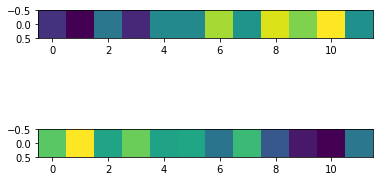

In [114]:
conv_layer = 'batch_normalization_12'
softmax_layer = 'dense_final'
n_channels=12
out_len=12
heatmap, orig = CAM_conv1D(model2, conv_layer, softmax_layer,  minimum_len, 
                                  n_channels, [clip_file2],[label2], out_len)

In [83]:
orig

[array([[1.     , 0.     , 0.     , 0.5    , 0.625  , 1.875  , 1.     ,
         1.     , 0.84375, 1.5    , 0.875  , 0.125  , 0.875  , 1.3125 ,
         1.4375 , 0.5    , 0.     , 1.625  , 1.75   , 1.5    , 1.25   ,
         0.     , 1.5    , 0.125  , 1.875  , 1.90625, 0.375  , 0.     ,
         0.875  , 0.1875 , 1.375  , 1.8125 , 0.5    , 1.125  , 0.5625 ,
         1.75   ]]),
 array([[1.     , 0.     , 0.     , 0.5    , 0.625  , 1.875  , 1.     ,
         1.     , 0.84375, 1.5    , 0.875  , 0.125  , 0.875  , 1.3125 ,
         1.4375 , 0.5    , 0.     , 1.625  , 1.75   , 1.5    , 1.25   ,
         0.     , 1.5    , 0.125  , 1.875  , 1.90625, 0.375  , 0.     ,
         0.875  , 0.1875 , 1.375  , 1.8125 , 0.5    , 1.125  , 0.5625 ,
         1.75   ]])]

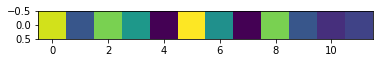

In [38]:
plt.imshow(heatmap[0])

In [56]:
heatmap[0]

array([[1.75  , 0.5   , 1.5   , 1.    , 0.    , 1.875 , 0.9375, 0.    ,
        1.5   , 0.5   , 0.25  , 0.375 ]])

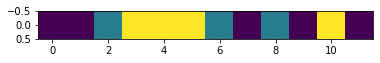

In [53]:
plt.imshow(att_map.reshape(1,12))

In [72]:
np.transpose(att_map[0])

array([[0.        , 0.        , 0.42041826, 1.        , 1.        ,
        1.        , 0.42041826, 0.        , 0.42041826, 0.        ,
        1.        , 0.        ]], dtype=float32)

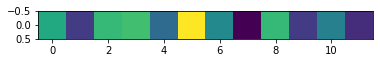

In [60]:
editted_map = (heatmap[0] + att_map.reshape(1,12))/2
plt.imshow(editted_map)

In [65]:
# file2=data_train[10]
import cv2
# tmp_file2 = np.load(mel_directory + '/' + file2.replace('.mat', '.npy'))
# clip_file2 = block_feature(tmp_file2, minimum_len)

# clip_file2 -= x_mean_final
# clip_file2 /= x_std_final
# clip_file2.shape
file2 = 'A4459.mat'
preprocessed_input2=clip_file2
preprocessed_input2 = np.reshape(preprocessed_input2, (1,minimum_len,12))
# preprocessed_input2.shape
outputs2 = model.predict(preprocessed_input2)
att_map2 = outputs2[2]
resize_att2 = cv2.resize(outputs2[2], (2880,1))
resize_editmap = cv2.resize(editted_map, (2880,1))

dot_edit = np.squeeze(preprocessed_input2) * np.transpose(resize_editmap)
dot_att = np.squeeze(preprocessed_input2) * np.transpose(resize_att2)

label2 = get_labels(input_directory, file2, class2index)
label2

[1, 0, 0, 0, 0, 0, 1, 0, 0]

In [66]:
file2

'A4459.mat'

In [67]:
clip_file2

array([[   -4459.50585071,  -720083.87160568,     5326.80712511, ...,
          -46550.53469529,    53484.12053887,    28765.55013094],
       [   -7580.45994621,  -851008.03007944,     5095.16333706, ...,
          -44193.59622971,    51911.02875832,    26710.79655016],
       [   -9363.86228649, -1025573.57471112,     6021.73848925, ...,
          -42425.89238052,    50337.93697776,    26197.10815497],
       ...,
       [  -26306.18451919, -1680194.36707993,     4168.58818486, ...,
          -82493.84629545,    75507.40546665,    48799.39754356],
       [  -28089.58685947, -1789297.83247473,     4400.23197291, ...,
          -83672.31552824,    73934.31368609,    51367.83951954],
       [  -28981.28802961, -1876580.60479057,     4863.51954901, ...,
          -84261.55014464,    73934.31368609,    52908.90470513]])

In [74]:
dot_att

array([[-0., -0.,  0., ..., -0.,  0.,  0.],
       [-0., -0.,  0., ..., -0.,  0.,  0.],
       [-0., -0.,  0., ..., -0.,  0.,  0.],
       ...,
       [-0., -0.,  0., ..., -0.,  0.,  0.],
       [-0., -0.,  0., ..., -0.,  0.,  0.],
       [-0., -0.,  0., ..., -0.,  0.,  0.]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


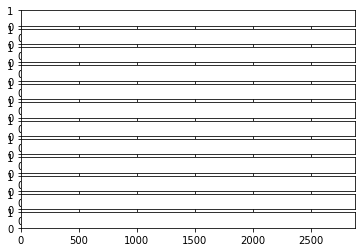

In [73]:
# normalize
dot_att_norm = (dot_att-dot_att.min())/(dot_att.max() - dot_att.min())
# dot_att on raw signal
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.pcolor(np.reshape(dot_att_norm[:,i], (1,2880)))

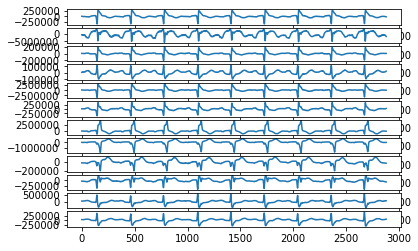

In [69]:
# Raw signal
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.reshape(clip_file2[:,i], (2880,1)))

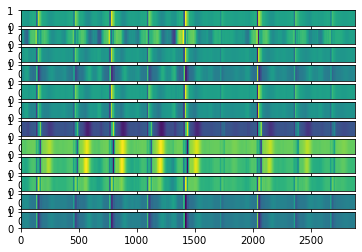

In [75]:
# dot_edit on raw signal
dot_edit_norm = (dot_edit-dot_edit.min())/(dot_edit.max() - dot_edit.min())
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.pcolor(np.reshape(dot_edit_norm[:,i], (1,2880)))

### Attention map을 ECG 위에 시각화

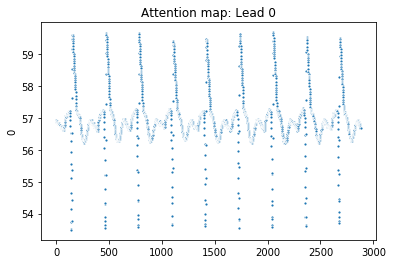

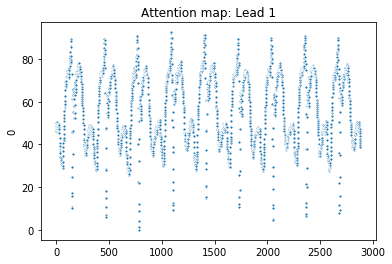

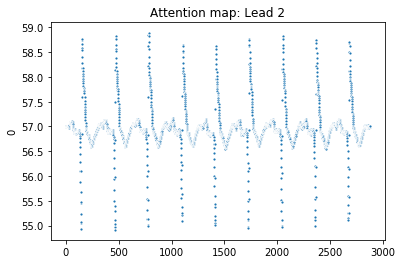

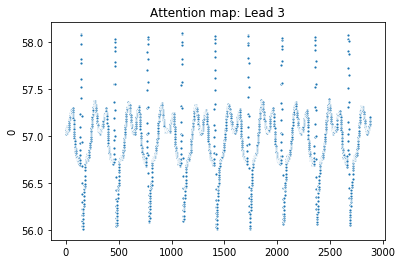

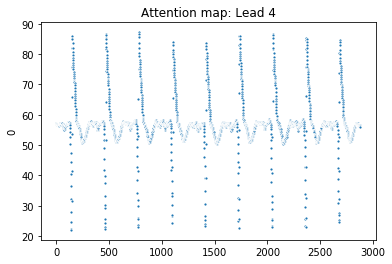

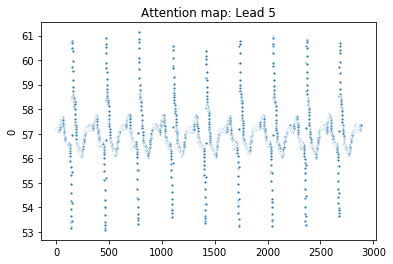

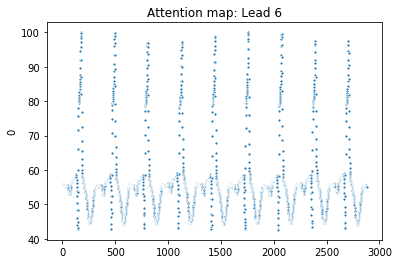

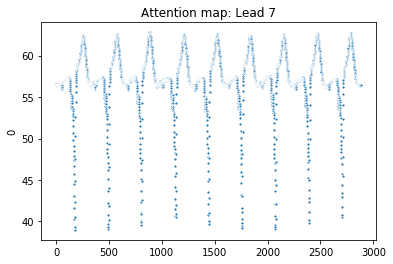

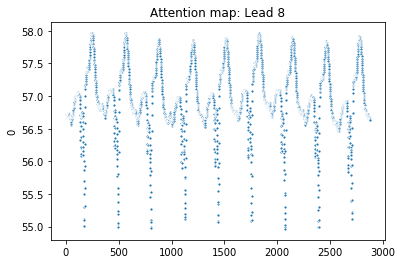

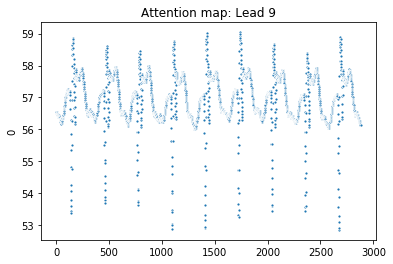

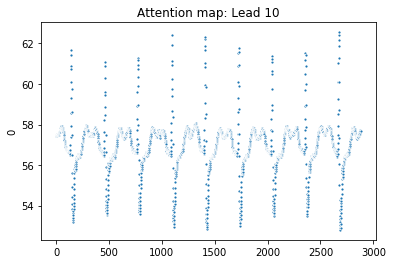

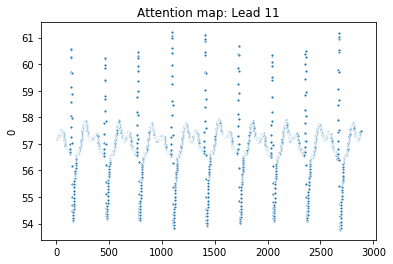

In [79]:
# 시각화를 위해 DataFrame으로 만들기?
import pandas as pd
import matplotlib as mpl
import seaborn as sns

clip_file3 = (clip_file2-clip_file2.min())/(clip_file2.max() - clip_file2.min())
clip_file3 = clip_file3*10**2 # for scaling
cmap = plt.get_cmap('plasma')

for i in range(12):
    plt.figure(i)
    plt.title("Attention map: Lead " + str(i))
    
    df = pd.DataFrame([clip_file3[:,i], dot_att_norm[:,i]])
    df = df.transpose()    
    sns.scatterplot(x=range(2880),y=0,hue=1, marker='.',palette=cmap,data=df, legend=None)

### CAM label 0 시각화

In [115]:
orig[0]

array([2500837.2, 1466188.5, 4228774.5, 2259406. , 4772635. , 4769076. ,
       7525554. , 5096038.5, 8093402. , 7104473. , 8462702. , 4974471. ,
       8312125.5, 5955659.5, 7820810. , 4761372. , 6898635.5, 5113374.5,
       6240010. , 6246556. , 7923132. , 8256968. , 7900686. , 9511636. ,
       8388032. , 8867922. , 6214332. , 7239659. , 6689987.5, 5788226. ,
       3749001. , 4264152. , 4352622. , 5623028.5, 2904643.2, 1215921.1],
      dtype=float32)

In [116]:
orig[1]

array([ 2868293.8  ,  4239491.5  ,  2008557.5  ,  3041348.5  ,
        1972513.6  ,  2021483.9  ,   943693.   ,  2535168.5  ,
         347068.84 ,  -760549.5  , -1122467.1  ,  1002705.1  ,
          80067.375,  -746548.2  ,  -380056.56 ,  3144806.5  ,
        2053082.5  ,  2028425.1  ,  2223513.8  ,  3358205.5  ,
       -1948580.8  , -3047522.   , -2580820.5  ,  1353594.1  ,
        -788896.1  ,  -489950.1  , -2042919.6  ,  1893499.   ,
         745473.4  ,  -850439.8  , -1740427.6  ,   989131.8  ,
       -1056841.5  ,  -926547.4  ,  -853322.7  ,   735228.6  ],
      dtype=float32)

In [ ]:
orig_0_norm = (dot_edit-dot_edit.min())/(dot_edit.max() - dot_edit.min())

In [123]:
edit_0 = (np.resize(orig[0], (1,12)) + att_map.reshape(1,12))/2
edit_1 = (np.resize(orig[1], (1,12)) + att_map.reshape(1,12))/2
resize_edit_0 = cv2.resize(edit_0, (2880,1))
resize_edit_1 = cv2.resize(edit_1, (2880,1))
dot_edit_0 = np.squeeze(preprocessed_input2) * np.transpose(resize_edit_0)
dot_edit_1 = np.squeeze(preprocessed_input2) * np.transpose(resize_edit_1)


dot_edit_0_norm = (dot_edit_0-dot_edit_0.min())/(dot_edit_0.max() - dot_edit_0.min())
dot_edit_1_norm = (dot_edit_1-dot_edit_1.min())/(dot_edit_1.max() - dot_edit_1.min())

In [118]:
dot_edit_0[0].shape

(12,)

In [119]:
clip_file3[:,i].shape

(2880,)

In [120]:
np.shape(dot_edit_0)

(2880, 12)

### CAM w.r.t. label 0 (=AF) 이 하이라이트 치는 부분

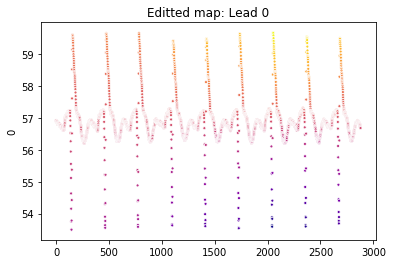

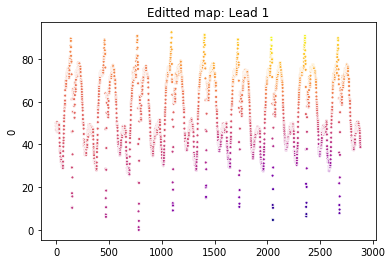

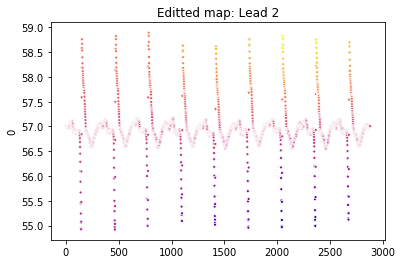

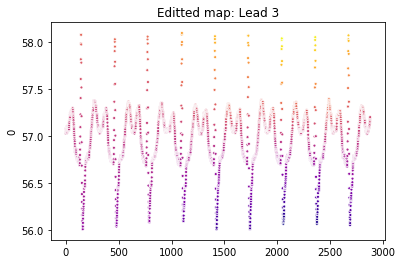

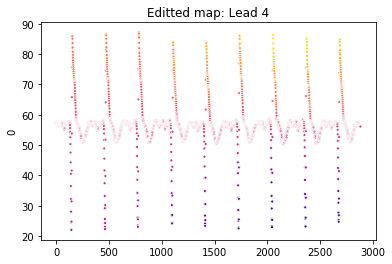

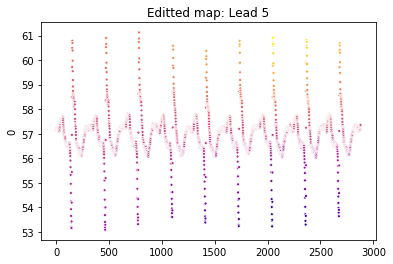

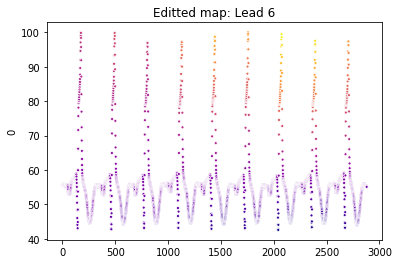

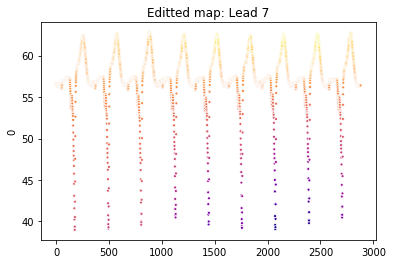

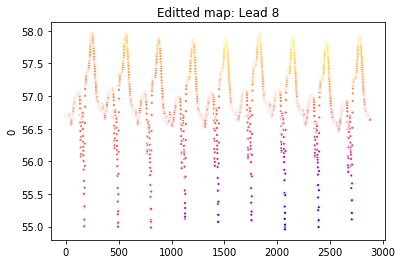

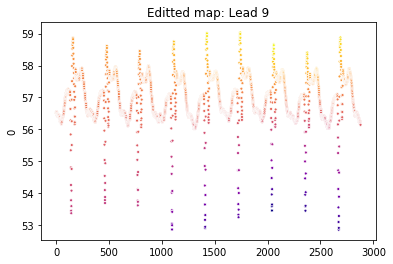

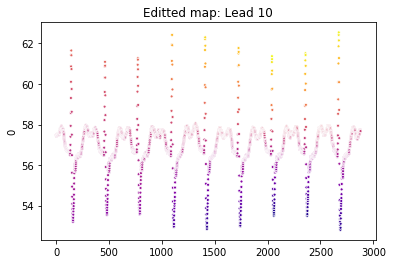

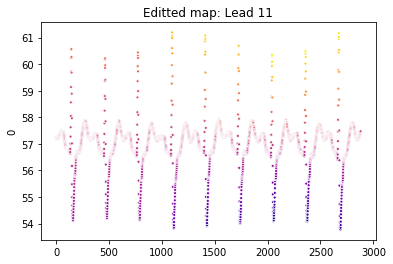

In [124]:

# dot_edit_norm = (dot_edit-dot_edit.min())/(dot_edit.max() - dot_edit.min())
# np.shape()
for i in range(12):
    plt.figure(i)
    plt.title("Editted map: Lead " + str(i))
    df = pd.DataFrame([clip_file3[:,i], dot_edit_0_norm[:,i]])
    df = df.transpose()    
    sns.scatterplot(x=range(2880),y=0,hue=1, marker='.',palette=cmap,data=df, legend=None)

### CAM w.r.t. label 6 (=RBBB)이 하이라이트 치는 부분

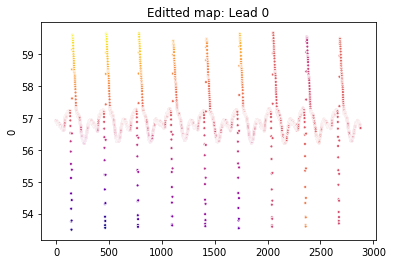

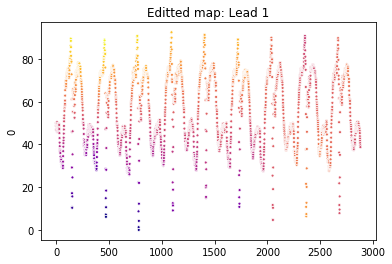

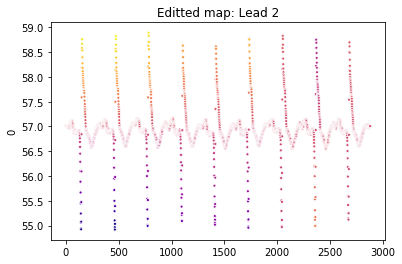

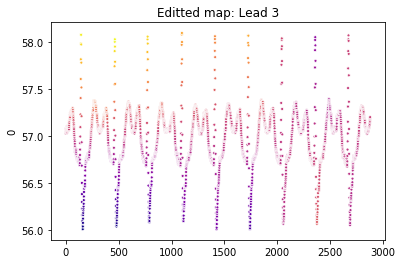

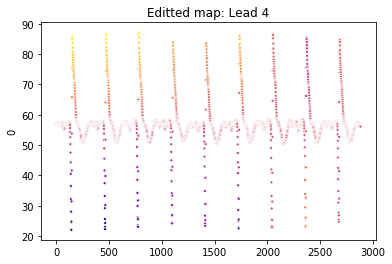

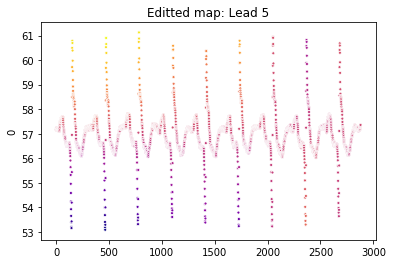

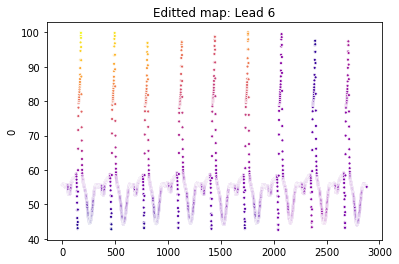

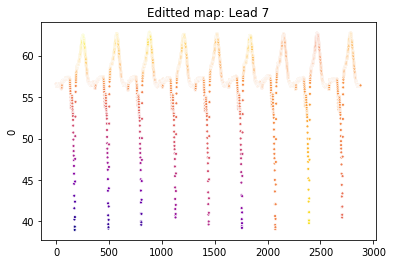

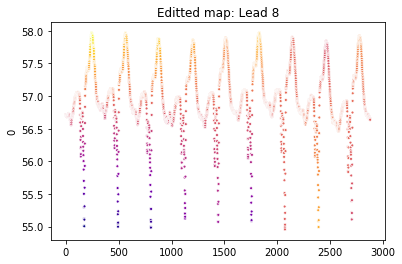

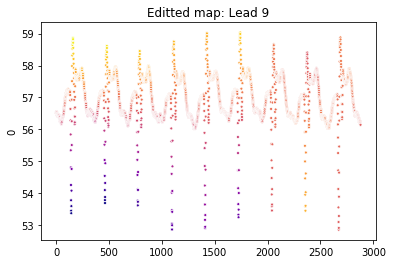

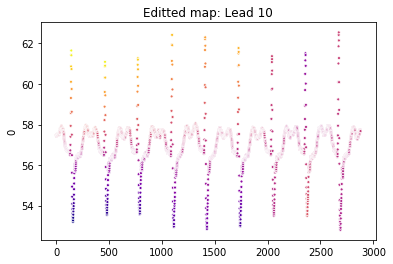

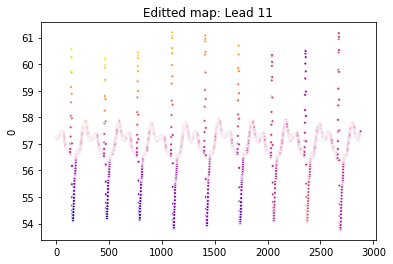

In [125]:
for i in range(12):
    plt.figure(i)
    plt.title("Editted map: Lead " + str(i))
    df = pd.DataFrame([clip_file3[:,i], dot_edit_1_norm[:,i]])
    df = df.transpose()    
    sns.scatterplot(x=range(2880),y=0,hue=1, marker='.',palette=cmap,data=df, legend=None)

### Editted map을 ECG 위에 시각화

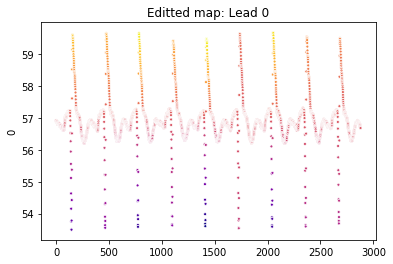

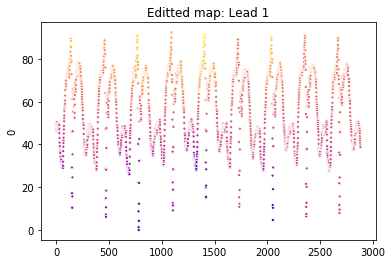

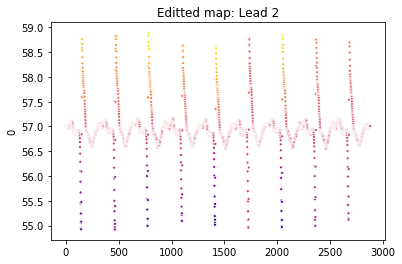

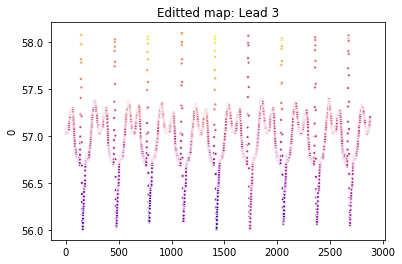

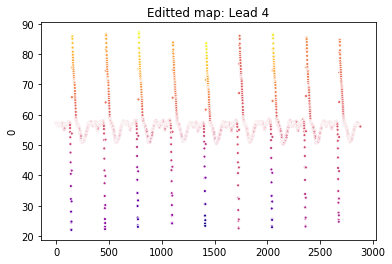

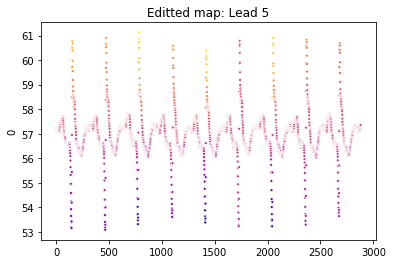

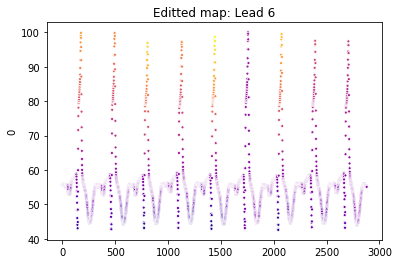

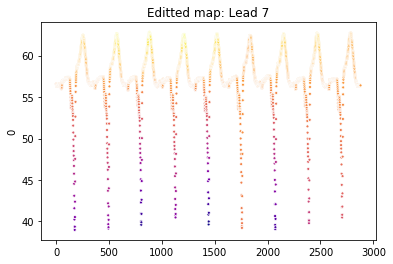

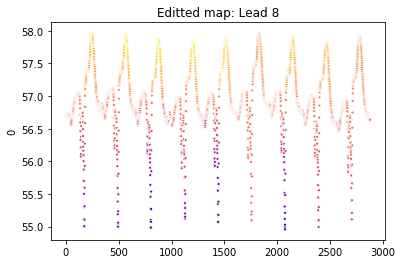

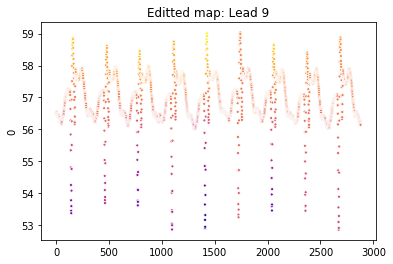

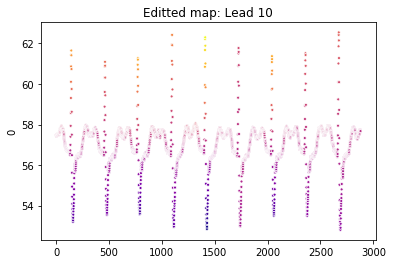

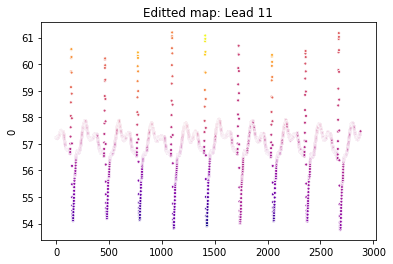

In [80]:
import pandas as pd
for i in range(12):
    plt.figure(i)
    plt.title("Editted map: Lead " + str(i))
    df = pd.DataFrame([clip_file3[:,i], dot_edit_norm[:,i]])
    df = df.transpose()    
    sns.scatterplot(x=range(2880),y=0,hue=1, marker='.',palette=cmap,data=df, legend=None)

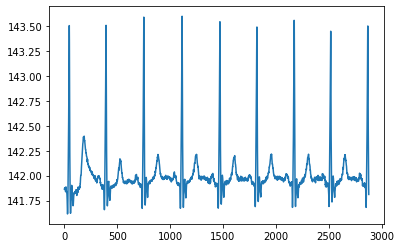

In [184]:
plt.plot(clip_file3[:,1])

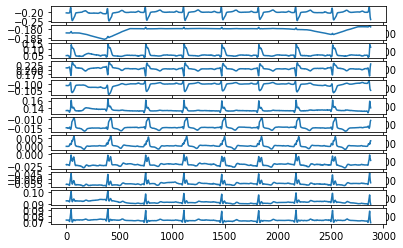

In [113]:
# dot_att * raw signal + raw signal
ABN = dot_att+np.squeeze(preprocessed_input2)
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.reshape(ABN[:,i], (2880,1)))

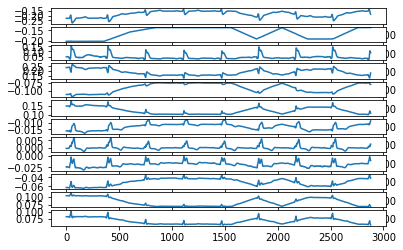

In [114]:
# dot_edit * raw_signal + raw signal
EDIT = dot_edit+np.squeeze(preprocessed_input2)
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.reshape(EDIT[:,i], (2880,1)))

In [72]:
class2index

{'AF': 0,
 'I-AVB': 1,
 'LBBB': 2,
 'Normal': 3,
 'PAC': 4,
 'PVC': 5,
 'RBBB': 6,
 'STD': 7,
 'STE': 8}